# Wordle

This is a fun project aimed to optimise finding the Wordle.

---
We adopt the following strategy:

1. start with an optimised initial guess. Here we use the following strategy
   * given the complete collection of English words (from nltk.corpus import words), restrict to 5-letter words
   * look for characters that occur most frequently (they would have the highest probabilities to occur in the actual wordle as well)
   * use these characters to form the best optimised first guess
  
2. before the next guess:
   * greys are eliminated from the list of alphabets
   * greens are held fixed in position for the next guess
   * oranges are kept making sure they occur in a different position, not already held by a green

3. repeat step 2.
---

In [1]:
import nltk
import pandas as pd
import regex as re

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rcParams['axes.linewidth'] = 1.
mpl.rcParams['axes.labelsize'] = 20.
mpl.rcParams['axes.titlesize'] = 14.
#mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['xtick.labelsize']= 14.
mpl.rcParams['ytick.labelsize']= 14.
mpl.rcParams['xtick.major.size']= 14.
mpl.rcParams['xtick.minor.size']= 1.5
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.major.size']= 14.
mpl.rcParams['ytick.minor.size']= 2.5
mpl.rcParams['ytick.direction'] = 'in' 
mpl.rcParams['lines.markersize']= 8
mpl.rcParams['lines.markeredgewidth']=2
mpl.rcParams['ytick.minor.size']= 3.
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.markerscale'] = 0.5
mpl.rcParams['legend.framealpha']=0.
mpl.rcParams['legend.borderaxespad']=4.0
mpl.rcParams['legend.handletextpad']=0.5
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'stixsans'

# List of words

In [3]:
from nltk.corpus import words

In [4]:
allwords = words.words()
print("Total number of words in the corpus: ", len(allwords))

Total number of words in the corpus:  236736


# List of 5-letter words

In [5]:
flcn = [word for word in allwords if len(word) == 5 and word.islower()]
print("Total number of 5-lettered words: ", len(flcn))

Total number of 5-lettered words:  8689


In [6]:
for word in [''.join(flcn)]:
    res = {i : word.count(i) for i in set(word)}
    
df = pd.Series(res)

In [7]:
#df.head()

# Frequency of characters
in the list of 5-letter words

<AxesSubplot:xlabel='Alphabets', ylabel='Counts'>

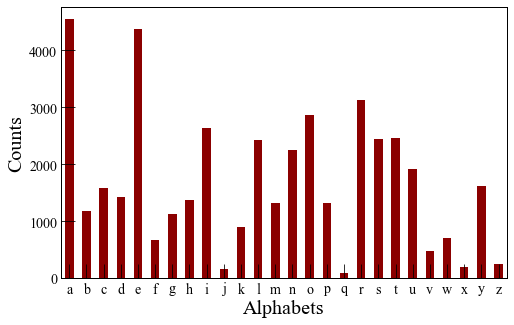

In [8]:
df.sort_index().plot.bar(color='darkred', xlabel='Alphabets', ylabel='Counts', figsize=(8,5), rot=0)

In [9]:
sorted(df.sort_values()[-5:].keys())

['a', 'e', 'i', 'o', 'r']

In [10]:
x = [word for word in flcn if sorted(word) == ['a', 'e', 'i', 'o', 'r']]
x

[]

---
The 5 most commonly occuring characters in our corpus are ['a', 'e', 'i', 'o', 'r']. However, we can't make a meaningful 5-letter word from them. So we move over to the next most commonly occuring letter.

---

In [11]:
sorted(df.sort_values()[-6:].keys())

['a', 'e', 'i', 'o', 'r', 't']

---
**Assumption:**  We make a choice here to use 't' in place of the least occuring vowel from the above list, to strike a balance between vowels and consonents.

---

# First Guess

In [12]:
x = [word for word in flcn if sorted(word) == ['a', 'e', 'i', 'r', 't']]
x

['arite', 'irate', 'retia', 'tarie']

---
Here, we can use any of the above four words as our first guess. We choose **'irate'**.


**First Guess: 'irate'**

<img src="./guess1.png" alt="drawing" width="400"/>

---

# Subsequent Guesses

Now, we follow the general strategy:
* eliminate greys
* fix greens
* shuffle oranges

In [13]:
# function to return a list of most-probable guesses
# given an eligible list of words and letters
# and provided information about greys, greens and oranges

def guess_maker(greys, greens, oranges, df_remaining_letters, word_list_remaining):
    
    print("#"*100)
    print(f"Number of (intial) eligible words: {len(word_list_remaining)}")
    print(f"Number of (intial) eligible letters: {len(df_remaining_letters.keys())}, {df_remaining_letters.keys()}")
    
    # drop greys and merge the remaining characters for a generic match pattern
    df = df_remaining_letters.drop(greys)
    x = "".join(df.keys())
    
    # generic match pattern (we take the approach of matching the most general word 
    # and then filtering the list based on sesequent conditions)
    match_pattern = f'^[{x}][{x}][{x}][{x}][{x}]$'
    
    # reduced list of words without greys
    word_list_grey = [word for word in word_list_remaining if re.match(match_pattern, word)]
    print(f"Number of words without greys, {greys}: {len(word_list_grey)}")
    
    
    # reduce word list accorinding to the fixed green positions
    word_list_green = word_list_grey # initialise
    for key in greens.keys():
        word_list_green = [word for word in word_list_green if word[greens[key]] == key]
        print(f"Number of remaining words with green {key} in position {greens[key]}: {len(word_list_green)}")
    
    # finally, incorporate the oranges in a copule of steps
    word_list_orange = word_list_green # initialise
    for key in oranges.keys():

        # make sure oranges appear atleast once...
        word_list_orange = [word for word in word_list_orange if re.search(key, word)]

        # ... and don't appear in their previous positions
        for pos in range(len(oranges[key])):
            word_list_orange = [word for word in word_list_orange if word[oranges[key][pos]] != key]
            print(f"Number of remaining words after orange operation for {key} in position {oranges[key][pos]}: {len(word_list_orange)}")
                    
    word_list_red = word_list_orange
    
    # update the frequency of characters in the remaining words
    for word in [''.join(word_list_red)]:
        res = {i : word.count(i) for i in set(word)}
    
    df = pd.Series(res)
    
    # and plot their distribution
    df.sort_index().plot.bar(color='darkred', xlabel='Alphabets', ylabel='Counts', figsize=(8,5), rot=0)
    
    print("Remaining letters (in decreasing order of frequency): ", len(df.sort_values()[::-1].keys()), df.sort_values()[::-1].keys())
    
    # Best guesses
    
    # The while loop iterates through the most frequently occuring letters
    # remaining in the list of alphabets
    tol = 4
    while tol < len(df):
        match_string = "".join(df.sort_values()[-tol:].keys())
        match_pattern = f'^[{match_string}][{match_string}][{match_string}][{match_string}][{match_string}]$'

        guess_list = [word for word in word_list_red if re.match(match_pattern, word) != None and len(list(set(word))) >= 4]
        
        # to most optimise our guess, we restrict to words where same letter does not appear
        # more than once in the word
        
        if not guess_list:
            print(f"Guess list is empty at tolerance {-tol}")
        else:
            break
        tol += 1
    
    print("-"*100)
    print("Best guesses: ", guess_list)
    print("-"*100)
            
    return df, word_list_red

## Second guess

####################################################################################################
Number of (intial) eligible words: 8689
Number of (intial) eligible letters: 26, Index(['s', 'h', 'c', 't', 'd', 'w', 'u', 'o', 'y', 'q', 'i', 'b', 'n', 'l',
       'e', 'p', 'r', 'm', 'z', 'x', 'a', 'k', 'g', 'v', 'f', 'j'],
      dtype='object')
Number of words without greys, ['a', 'i', 't']: 2207
Number of remaining words after orange operation for r in position 1: 664
Number of remaining words after orange operation for e in position 4: 328
Remaining letters (in decreasing order of frequency):  23 Index(['e', 'r', 'o', 'y', 'u', 'l', 's', 'd', 'p', 'b', 'm', 'n', 'w', 'c',
       'v', 'h', 'g', 'f', 'k', 'x', 'j', 'q', 'z'],
      dtype='object')
Guess list is empty at tolerance -4
Guess list is empty at tolerance -5
----------------------------------------------------------------------------------------------------
Best guesses:  ['leery', 'lurer', 'lyery', 'roleo', 'ruler', 'uller

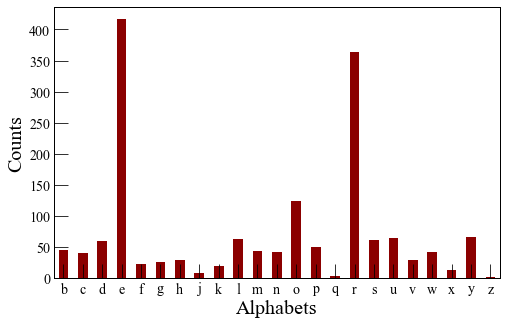

In [14]:
greys = ['a', 'i', 't']
greens = {}
oranges = {'r': [1],
          'e': [4]}

df2, flcn2 = guess_maker(greys, greens, oranges, df, flcn)

---
**Second Guess: 'lurer'**

<img src="./guess2.png" alt="drawing" width="400"/>

---

## Third Guess

####################################################################################################
Number of (intial) eligible words: 328
Number of (intial) eligible letters: 23, Index(['s', 'h', 'c', 'd', 'w', 'u', 'o', 'y', 'q', 'b', 'n', 'l', 'e', 'p',
       'r', 'm', 'z', 'x', 'g', 'k', 'v', 'f', 'j'],
      dtype='object')
Number of words without greys, ['l']: 266
Number of remaining words with green u in position 1: 22
Number of remaining words after orange operation for r in position 1: 22
Number of remaining words after orange operation for r in position 2: 17
Number of remaining words after orange operation for e in position 3: 2
Number of remaining words after orange operation for e in position 4: 2
Remaining letters (in decreasing order of frequency):  6 Index(['r', 'q', 'e', 'u', 'y', 'n'], dtype='object')
Guess list is empty at tolerance -4
----------------------------------------------------------------------------------------------------
Best guesses:  ['query']
-----

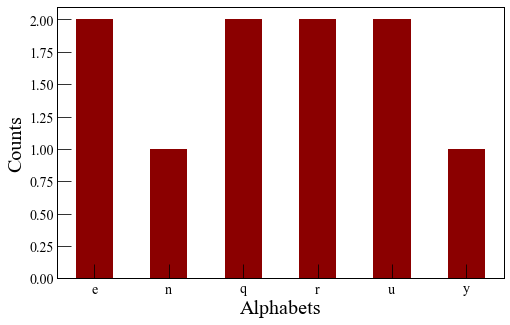

In [15]:
greys = ['l']
greens = {'u': 1}
oranges = {'r': [1,2],
          'e': [3,4]}

df3, flcn3 = guess_maker(greys, greens, oranges, df2, flcn2)

---
**Second Guess: 'query'**

<img src="./guess3.png" alt="drawing" width="400"/>

---

## Fourth Guess

greys = []
greens = {}
oranges = {}

df4, flcn4 = guess_maker(greys, greens, oranges, df3, flcn3)

## Fifth Guess

greys = []
greens = {}
oranges = {}

df5, flcn5 = guess_maker(greys, greens, oranges, df4, flcn4)

# Last Guess

greys = []
greens = {}
oranges = {}

df6, flcn6 = guess_maker(greys, greens, oranges, df5, flcn5)

# Plots outlining the above data analysis technique

## How the relative importance of each letter change after each guess?

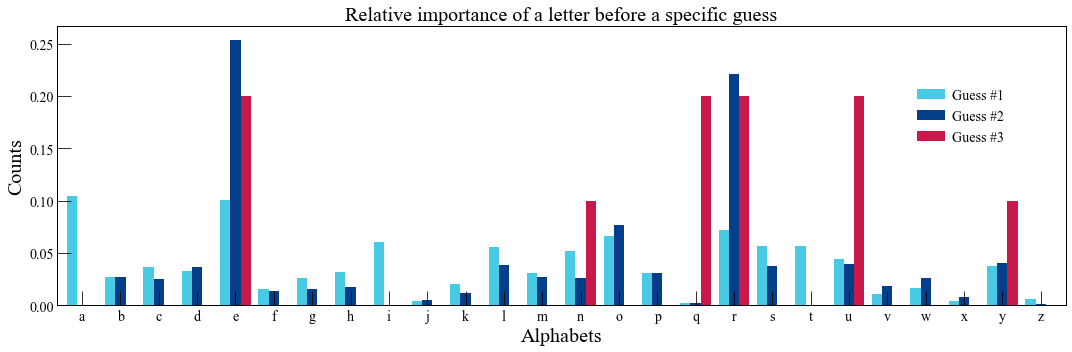

In [16]:
dfn = {'df1': df,
      'df2': df2, 
      'df3': df3}
dfn = pd.concat(dfn,
               axis = 1)

dfn.fillna(0, inplace=True)

dfn["df1"] = dfn["df1"]/dfn["df1"].sum()
dfn["df2"] = dfn["df2"]/dfn["df2"].sum()
dfn["df3"] = dfn["df3"]/dfn["df3"].sum()


dfn.sort_index().plot.bar(color={'df1': '#48cae4', 'df2': '#023e8a', 'df3': '#c9184a'}, 
                          xlabel='Alphabets', ylabel='Counts', figsize=(15,5), rot=0,
                         width=0.8)

plt.legend(["Guess #1", "Guess #2", "Guess #3"])
plt.title("Relative importance of a letter before a specific guess", fontsize=20)
plt.tight_layout()